## Dependencies

In [1]:
#@title Cyclical Learning Rate
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
                new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
#@title Libraries
!pip3 install transformers
!pip3 install torch-lr-finder

# TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds

# HuggingFace NLP library
from transformers import TFBertForSequenceClassification, BertTokenizer 

# Evaluasi model
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime

In [ ]:
#@title Dataset
CONTEXT_T = 'contexttrain.csv'
CONTEXT_S = 'contexttest.csv'

INTENT_T = 'intenttrain.csv'
INTENT_S = 'intenttest.csv'

SENTIMENT_T = 'sentimenttrain.csv'
SENTIMENT_S = 'sentimenttest.csv'

context_train = tf.data.experimental.CsvDataset([CONTEXT_T], 
                                            record_defaults = [tf.constant([""], dtype=tf.string), tf.constant([0.0], dtype=tf.float64)],
                                            header=True) 
context_test = tf.data.experimental.CsvDataset([CONTEXT_S], 
                                           record_defaults = [tf.constant([""], dtype=tf.string), tf.constant([0.0], dtype=tf.float64)],
                                           header=True) 

intent_train = tf.data.experimental.CsvDataset([INTENT_T], 
                                            record_defaults = [tf.constant([""], dtype=tf.string), tf.constant([0.0], dtype=tf.float64)],
                                            header=True) 
intent_test = tf.data.experimental.CsvDataset([INTENT_S], 
                                           record_defaults = [tf.constant([""], dtype=tf.string), tf.constant([0.0], dtype=tf.float64)],
                                           header=True) 

sentiment_train = tf.data.experimental.CsvDataset([SENTIMENT_T], 
                                            record_defaults = [tf.constant([""], dtype=tf.string), tf.constant([0.0], dtype=tf.float64)],
                                            header=True) 
sentiment_test = tf.data.experimental.CsvDataset([SENTIMENT_S], 
                                           record_defaults = [tf.constant([""], dtype=tf.string), tf.constant([0.0], dtype=tf.float64)],
                                           header=True) 

CONTEXT_CLASSES = ['Policies', 'Vaccination', 'Daily Life', 'Random']
INTENT_CLASSES = ['Opinion', 'Complaint', 'Suggestion', 'News', 'Random', 'Query']
SENTIMENT_CLASSES = ['Positive', 'Negative', 'Neutral']

## Preprocess

In [ ]:
#@title Transfer Learning Model
MODEL_NAME = "indobenchmark/indobert-base-p2"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [ ]:
#@title Sentence to Features
MAX_LENGTH = 65
def convert_sentence_to_features(sentence):
  return tokenizer.encode_plus(
                        sentence,       
                        max_length = MAX_LENGTH, # max length of the text that can go to BERT [Step 2]            
                        add_special_tokens = True, # add special tokens  [Step 1]
                        pad_to_max_length = True, # add [PAD] tokens [Step 3]
                        return_attention_mask = True, # add attention mask to not focus on pad tokens, [Step 4]
                        truncation=True # Truncate to a maximum length specified with the argument max_length
              )
  
def map_features_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_sentences(dataset):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for message, label in tfds.as_numpy(dataset):
    bert_input = convert_sentence_to_features(message.decode())
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_features_to_dict)

In [ ]:
#@title Batching and Shuffling
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 20000

context_train_encoded = encode_sentences(context_train).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
intent_train_encoded = encode_sentences(intent_train).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
sentiment_train_encoded = encode_sentences(sentiment_train).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

context_test_encoded = encode_sentences(context_test).batch(BATCH_SIZE)
intent_test_encoded = encode_sentences(intent_test).batch(BATCH_SIZE)
sentiment_test_encoded = encode_sentences(sentiment_test).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Training

In [ ]:
#@title Model Initialization
context_model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
intent_model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6)
sentiment_model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

In [ ]:
#@title Tensorboard Callbacks
import datetime
import os

os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = tensorboard_log_dir,
    histogram_freq = 1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience = 5,
    monitor = 'val_accuracy'
)

### Context Model

In [ ]:
#@title Compile Model
%load_ext tensorboard
!rm -rf ./logs/

context_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

!rm -rf tmp/checkpoints
!rm -rf logs

In [ ]:
#@title Train Model
context_history = context_model.fit(context_train_encoded,
                  epochs=5,
                  validation_data=context_test_encoded,
                  callbacks=[tensorboard_callback])

### Intent Model

In [ ]:
#@title Compile Model
%reload_ext tensorboard
!rm -rf ./logs/

intent_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

!rm -rf tmp/checkpoints
!rm -rf logs

In [ ]:
#@title Train Model
intent_history = intent_model.fit(intent_train_encoded,
                  epochs=5,
                  validation_data=intent_test_encoded,
                  callbacks=[tensorboard_callback])

### Sentiment Model

In [ ]:
#@title Compile Model
%reload_ext tensorboard
!rm -rf ./logs/

sentiment_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

!rm -rf tmp/checkpoints
!rm -rf logs

In [ ]:
#@title Train Model
sentiment_history = sentiment_model.fit(sentiment_train_encoded,
                    epochs=5,
                    validation_data=sentiment_test_encoded,
                  callbacks=[tensorboard_callback])

## Evaluasi

In [ ]:
#@title Context Model
_, train_acc = context_model.evaluate(context_train_encoded)
_, test_acc = context_model.evaluate(context_test_encoded)

print("train acc", train_acc)
print("test acc", test_acc)

36/36 [==============================] - 10s 273ms/step - loss: 0.3438 - accuracy: 0.8872
train acc 0.9577433466911316
test acc 0.8871681690216064


In [ ]:
y_true_context = []
for message, label in tfds.as_numpy(context_test):
  y_true_context.append(label)

y_pred_context = context_model.predict(context_test_encoded)[0].argmax(axis=-1)

In [ ]:
#@title Intent Model
_, train_acc = intent_model.evaluate(intent_train_encoded)
_, test_acc = intent_model.evaluate(intent_test_encoded)

print("train acc", train_acc)
print("test acc", test_acc)

36/36 [==============================] - 10s 272ms/step - loss: 0.5569 - accuracy: 0.8097
train acc 0.9105088710784912
test acc 0.8097345232963562


In [ ]:
y_true_intent = []
for message, label in tfds.as_numpy(intent_test):
  y_true_intent.append(label)

y_pred_intent = intent_model.predict(intent_test_encoded)[0].argmax(axis=-1)

In [ ]:
#@title Sentiment Model
_, train_acc = sentiment_model.evaluate(sentiment_train_encoded)
_, test_acc = sentiment_model.evaluate(sentiment_test_encoded)

print("train acc", train_acc)
print("test acc", test_acc)

36/36 [==============================] - 10s 271ms/step - loss: 0.4049 - accuracy: 0.8442
train acc 0.9566371440887451
test acc 0.8442477583885193


In [ ]:
y_true_sentiment = []
for message, label in tfds.as_numpy(sentiment_test):
  y_true_sentiment.append(label)

y_pred_sentiment = sentiment_model.predict(sentiment_test_encoded)[0].argmax(axis=-1)

In [ ]:
CONTEXT_CLASSES = ['Policies', 'Vaccination', 'Daily Life', 'Random']
INTENT_CLASSES = ['Opinion', 'Complaint', 'Suggestion', 'News', 'Random', 'Query']
SENTIMENT_CLASSES = ['Positive', 'Negative', 'Neutral']

### *Classification report*

In [ ]:
print(classification_report(y_true_context, y_pred_context, target_names=CONTEXT_CLASSES))

              precision    recall  f1-score   support

    Policies       0.77      0.75      0.76       298
 Vaccination       0.95      0.97      0.96       577
  Daily Life       0.86      0.83      0.84       419
      Random       0.89      0.91      0.90       966

    accuracy                           0.89      2260
   macro avg       0.87      0.86      0.87      2260
weighted avg       0.89      0.89      0.89      2260



In [ ]:
print(classification_report(y_true_intent, y_pred_intent, target_names=INTENT_CLASSES))

              precision    recall  f1-score   support

     Opinion       0.79      0.63      0.70       289
   Complaint       0.65      0.75      0.70       220
  Suggestion       0.44      0.43      0.43        42
        News       0.81      0.91      0.86       822
      Random       0.89      0.83      0.86       856
       Query       0.55      0.39      0.45        31

    accuracy                           0.81      2260
   macro avg       0.69      0.66      0.67      2260
weighted avg       0.81      0.81      0.81      2260



In [ ]:
print(classification_report(y_true_sentiment, y_pred_sentiment, target_names=SENTIMENT_CLASSES))

              precision    recall  f1-score   support

    Positive       0.61      0.62      0.62       207
    Negative       0.88      0.83      0.85       776
     Neutral       0.86      0.89      0.88      1277

    accuracy                           0.84      2260
   macro avg       0.78      0.78      0.78      2260
weighted avg       0.85      0.84      0.84      2260



### Confusion Matrix

In [ ]:
#@title Context Model Confusion Matrix
from sklearn.metrics import confusion_matrix
context_matrix = [[223, 9, 17, 49], [2, 561, 3, 11], [21, 7, 346, 45], [45, 12, 34, 875]]

import seaborn as sns
import numpy as np
import pandas as pd

tick = ['Kebijakan', 'Vaksinasi', 'Dinamika Masyarakat', 'Lainnya']

sns.heatmap(context_matrix/np.sum(context_matrix), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=tick, yticklabels=tick)

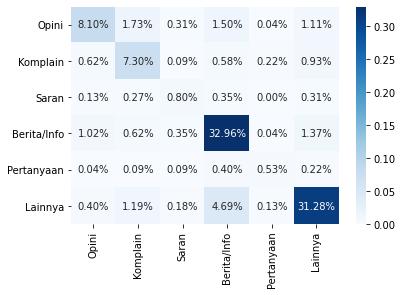

In [ ]:
#@title Intent Model Confusion Matrix
intent_matrix = [[183, 39, 7, 34, 1, 25], [14, 165, 2, 13, 5, 21], [3, 6, 18, 8, 0, 7], [23, 14, 8, 745, 1, 31], [1, 2, 2, 9, 12, 5], [9, 27, 4, 106, 3, 707]]

tick = ['Opini', 'Komplain', 'Saran', 'Berita/Info', 'Pertanyaan', 'Lainnya']

sns.heatmap(intent_matrix/np.sum(intent_matrix), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=tick, yticklabels=tick)

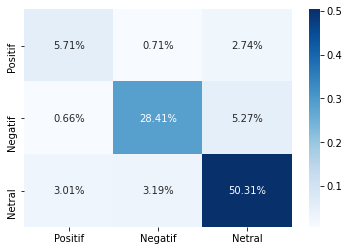

In [ ]:
#@title Sentiment Model Confusion Matrix
sentiment_matrix = [[129, 16, 62], [15, 642, 119], [68, 72, 1137]]

tick = ['Positif', 'Negatif', 'Netral']

sns.heatmap(sentiment_matrix/np.sum(sentiment_matrix), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=tick, yticklabels=tick)

## Prediksi

In [ ]:
#@title Regex
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None) # set column width to maximum so we can see the entire text
import string
from string import digits
import re

REGEX_URL = re.compile(
    r"(?:^|(?<![\w\/\.]))"
    # protocol identifier
    # r"(?:(?:https?|ftp)://)"
    r"(?:(?:https?:\/\/|ftp:\/\/|www\d{0,3}\.))"
    # user:pass authentication
    r"(?:\S+(?::\S*)?@)?" r"(?:"
    # IP address exclusion
    # private & local networks
    r"(?!(?:10|127)(?:\.\d{1,3}){3})"
    r"(?!(?:169\.254|192\.168)(?:\.\d{1,3}){2})"
    r"(?!172\.(?:1[6-9]|2\d|3[0-1])(?:\.\d{1,3}){2})"
    # IP address dotted notation octets
    # excludes loopback network 0.0.0.0
    # excludes reserved space >= 224.0.0.0
    # excludes network & broadcast addresses
    # (first & last IP address of each class)
    r"(?:[1-9]\d?|1\d\d|2[01]\d|22[0-3])"
    r"(?:\.(?:1?\d{1,2}|2[0-4]\d|25[0-5])){2}"
    r"(?:\.(?:[1-9]\d?|1\d\d|2[0-4]\d|25[0-4]))"
    r"|"
    # host name
    r"(?:(?:[a-z\\u00a1-\\uffff0-9]-?)*[a-z\\u00a1-\\uffff0-9]+)"
    # domain name
    r"(?:\.(?:[a-z\\u00a1-\\uffff0-9]-?)*[a-z\\u00a1-\\uffff0-9]+)*"
    # TLD identifier
    r"(?:\.(?:[a-z\\u00a1-\\uffff]{2,}))" r"|" r"(?:(localhost))" r")"
    # port number
    r"(?::\d{2,5})?"
    # resource path
    r"(?:\/[^\)\]\}\s]*)?",
    # r"(?:$|(?![\w?!+&\/\)]))",
    flags=re.UNICODE | re.IGNORECASE,
)

REGEX_NUMBER =re.compile(
    r"(?:^|(?<=[^\w,.]))[+–-]?(([1-9]\d{0,2}(,\d{3})+(\.\d*)?)|([1-9]\d{0,2}([ .]\d{3})+(,\d*)?)|(\d*?[.,]\d+)|\d+)(?:$|(?=\b))"
)

def replace(text, regex_pattern, replacement):
  return regex_pattern.sub(replacement, text)

def replace_urls(text, symbol = "<URL>"):
  return replace(text, REGEX_URL, symbol)

def replace_numbers(text, symbol = "<NUM>") -> str:
  return replace(text, REGEX_NUMBER, symbol)

def clean_numbers(text):
  return text.translate({ord(k): None for k in digits})

def replace_punctuations(
        text, symbol = "<PUNCT>", exceptions= []
    ):
    all_punct = [punct for punct in string.punctuation]
    punct_to_remove = "".join(
        [punct for punct in all_punct if punct not in exceptions]
    )
    result = re.sub(r"[" + str(punct_to_remove) + "]+\ *", " " + symbol + " ", text)

    return result

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

def replace_words_by_dictionary(text, dictionary):
    new_text = []
    for word in text.split():
        if word in dictionary:
            new_text.append(dictionary[word])
        else:
            new_text.append(word)

    return " ".join(new_text)

def stem(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  output   = stemmer.stem(text)

  return output

def preprocess(text):

  # \n
  text = re.sub('\n', ' ', text)

  # Username
  text = re.sub('@[^\s]+','', text)
  
  # Lowercase
  text = text.lower()

  # Replace URL with tag
  text = replace_urls(text)

  # Remove punctuation
  text = replace_punctuations(text,  symbol="", exceptions=["<", ">"])

  # Replace numbers with tag
  text = replace_numbers(text)

  text = clean_numbers(text)

  return text

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
#@title Input Function
def predict(input):

  input = preprocess(input)
  message = remove_emojis(input)

  input_ids_list1 = []
  token_type_ids_list1 = []
  attention_mask_list1 = []
  label_list1 = []
    
  bert_input1 = convert_sentence_to_features(message)
  input_ids_list1.append(bert_input1['input_ids'])
  token_type_ids_list1.append(bert_input1['token_type_ids'])
  attention_mask_list1.append(bert_input1['attention_mask'])
  label_list1.append(2)

  ds_predict1 = tf.data.Dataset.from_tensor_slices((input_ids_list1, attention_mask_list1, token_type_ids_list1, label_list1)).map(map_features_to_dict).batch(BATCH_SIZE)
  
  predicted_probs1 =  context_model.predict(ds_predict1)[0]
  predicted_idx1 = predicted_probs1[0].argmax(axis=-1)
  predicted_label1 = CONTEXT_CLASSES[predicted_idx1]

  input_ids_list2 = []
  token_type_ids_list2 = []
  attention_mask_list2 = []
  label_list2 = []
    
  bert_input2 = convert_sentence_to_features(message)
  input_ids_list2.append(bert_input2['input_ids'])
  token_type_ids_list2.append(bert_input2['token_type_ids'])
  attention_mask_list2.append(bert_input2['attention_mask'])
  label_list2.append(2)

  ds_predict2 = tf.data.Dataset.from_tensor_slices((input_ids_list2, attention_mask_list2, token_type_ids_list2, label_list2)).map(map_features_to_dict).batch(BATCH_SIZE)
  
  predicted_probs2 =  intent_model.predict(ds_predict2)[0]
  predicted_idx2 = predicted_probs2[0].argmax(axis=-1)
  predicted_label2 = INTENT_CLASSES[predicted_idx2]

  input_ids_list3 = []
  token_type_ids_list3 = []
  attention_mask_list3 = []
  label_list3 = []
    
  bert_input3 = convert_sentence_to_features(message)
  input_ids_list3.append(bert_input3['input_ids'])
  token_type_ids_list3.append(bert_input3['token_type_ids'])
  attention_mask_list3.append(bert_input3['attention_mask'])
  label_list3.append(2)

  ds_predict3 = tf.data.Dataset.from_tensor_slices((input_ids_list3, attention_mask_list3, token_type_ids_list3, label_list3)).map(map_features_to_dict).batch(BATCH_SIZE)
  
  predicted_probs3 =  sentiment_model.predict(ds_predict3)[0]
  predicted_idx3 = predicted_probs3[0].argmax(axis=-1)
  predicted_label3 = SENTIMENT_CLASSES[predicted_idx3]

  return message, predicted_label1, predicted_label2, predicted_label3, predicted_idx1, predicted_idx2, predicted_idx3
  # return print('{}: {} {} {}'.format(message, predicted_label1, predicted_label2, predicted_label3))

In [ ]:
predict("@KediriFess etdah perasaan ada menfess yg jelasin deh daripada nanya bolak balik bisa kok ketik di pencarian ""kedirifess"" trs masukin apa yg mau di cari, semua adaa :( misal kedirifess ppkm. ntr muncul tuh daripada nanya bolak balik woi heran dah")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(' etdah perasaan ada menfess yg jelasin deh daripada nanya bolak balik bisa kok ketik di pencarian kedirifess trs masukin apa yg mau di cari  semua adaa   misal kedirifess ppkm  ntr muncul tuh daripada nanya bolak balik woi heran dah',
 'Daily Life',
 'Complaint',
 'Negative')

In [ ]:
predict('@wiriantowidjaya @luhutbinsarp Mas Wir silakan baca keterangan beliau, meskipun ppkm, orang asing, tka China boleh masuk. Begitu kebijakannya. Kalau saya jumpa dg beliau, saya akan usul, selama PPKM tutup dulu bandara internasional itu. Kalau dia setuju. Yg mikirin covid ini, bukan cuma dia. Kok buruk sangka?')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('  mas wir silakan baca keterangan beliau  meskipun ppkm  orang asing  tka china boleh masuk  begitu kebijakannya  kalau saya jumpa dg beliau  saya akan usul  selama ppkm tutup dulu bandara internasional itu  kalau dia setuju  yg mikirin covid ini  bukan cuma dia  kok buruk sangka  ',
 'Policies',
 'Opinion',
 'Negative')

In [ ]:
predict('iya aku setuju sama statement "jangan ngambil keuntungan dari pandemi". tapi perusahaan gak sebaik hati itu buat bagiin vaksin gratis hmz.')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('iya aku setuju sama statement   jangan ngambil keuntungan dari pandemi  tapi perusahaan gak sebaik hati itu buat bagiin vaksin gratis hmz  ',
 'Vaccination',
 'Opinion',
 'Negative')

In [ ]:
predict('hadeh gila covid udah sebegini nya aja masih ada aja orang beli makan ga pake masker, udah gitu pegang2 makanan nya pake tangan dia lagi astaga, padahal even lagi ga covid tetep jorok banget sih anjing mana tau u abis ngupil atau garuk pantat. bismilah aja dah ni w makan nasduk')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('hadeh gila covid udah sebegini nya aja masih ada aja orang beli makan ga pake masker  udah gitu pegang makanan nya pake tangan dia lagi astaga  padahal even lagi ga covid tetep jorok banget sih anjing mana tau u abis ngupil atau garuk pantat  bismilah aja dah ni w makan nasduk',
 'Daily Life',
 'Complaint',
 'Negative')

In [ ]:
predict('Semua pihak harus bekerja sama, saling tolong menolong agar pandemi ini cepat berlalu #JokowiBerantasCovid https://t.co/3WUuUpQfdM')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('semua pihak harus bekerja sama  saling tolong menolong agar pandemi ini cepat berlalu   jokowiberantascovid <URL>',
 'Random',
 'News',
 'Positive')

In [ ]:
predict('@tm_endik @tirta_hudhi menurut saya pernyataan resmi IDI tidak cukup, karna kita berhadapan dengan pandemi, korbannya banyak nyawa. NYAWA. Kalau berani berargumen tp ga berani pertanggungjawabkan, untuk apa? sekalian lanjut proses hukum saja, adu2an hasil penelitian di pengadilan')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('  menurut saya pernyataan resmi idi tidak cukup  karna kita berhadapan dengan pandemi  korbannya banyak nyawa  nyawa  kalau berani berargumen tp ga berani pertanggungjawabkan  untuk apa  sekalian lanjut proses hukum saja  aduan hasil penelitian di pengadilan',
 'Policies',
 'Opinion',
 'Negative')

In [ ]:
predict('''Kalau mikirin diri sendiri mah bodo amat ada Vaksin Berbayar..

Wong aku juga dapatnya Vaksin gratis..

Tapi itu ga buat aku ga kritisi vaksin Berbayar..

Ini bukan kegagalan Jokowi, tapi kegagalan para pengusung vaksin berbayar..

Kalian yang gagal tapi korbankan Jokowi..''')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('kalau mikirin diri sendiri mah bodo amat ada vaksin berbayar  wong aku juga dapatnya vaksin gratis  tapi itu ga buat aku ga kritisi vaksin berbayar  ini bukan kegagalan jokowi  tapi kegagalan para pengusung vaksin berbayar  kalian yang gagal tapi korbankan jokowi  ',
 'Vaccination',
 'Opinion',
 'Negative')

In [ ]:
predict('PPKM = Pagi Pagi Kok Marah https://t.co/zLaXN9yT1O')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('ppkm   pagi pagi kok marah <URL>', 'Random', 'Random', 'Neutral')

In [ ]:
predict('Pagi ini dapat kabar ibunda teman saya meninggal karena covid-19. Saya cuma bisa nguatin dia agar dia bisa nguatin keluarganya yang lain. Covid-19 ini bener-bener bahaya. Jangan lupa tetep 5M dan hindari kerumunan.')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('pagi ini dapat kabar ibunda teman saya meninggal karena covid  <NUM>  saya cuma bisa nguatin dia agar dia bisa nguatin keluarganya yang lain  covid  <NUM> ini bener  bener bahaya  jangan lupa tetep m dan hindari kerumunan  ',
 'Daily Life',
 'Opinion',
 'Positive')

In [ ]:
predict('Semangat semua ayo kita vaksin pasti kita bersama bisa melewati pandemi ini tetap semangat:)')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('semangat semua ayo kita vaksin pasti kita bersama bisa melewati pandemi ini tetap semangat  ',
 'Vaccination',
 'Suggestion',
 'Positive')

In [ ]:
predict('@republikaonline Kami tidak butuh vaksin..kami butuh beras..Kami tidak mati karena terpapar,tapi mati karena lapar terkapar.tolong bantu kami bu/pak..negeri ini akan selalu kena bencana,selama air mata fakir miskin masih menetes karena teraniaya kelaparan..Allahu akbar..azab Allah bagi orang kaya')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(' kami tidak butuh vaksin  kami butuh beras  kami tidak mati karena terpapar  tapi mati karena lapar terkapar  tolong bantu kami bu  pak  negeri ini akan selalu kena bencana  selama air mata fakir miskin masih menetes karena teraniaya kelaparan  allahu akbar  azab allah bagi orang kaya',
 'Daily Life',
 'Complaint',
 'Negative')

In [ ]:
predict('@DenpasarKota Mau vaksin kok malah membahayakan masyarakatnya dgn antri kayak pepesan. Blm lg dgn ketersediaan vaksin yg terbatas. Datang ambil nomer jam 3 pagi sudah habis, di mn aturanmu pemerintah????? @jokowi')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(' mau vaksin kok malah membahayakan masyarakatnya dgn antri kayak pepesan  blm lg dgn ketersediaan vaksin yg terbatas  datang ambil nomer jam <NUM> pagi sudah habis  di mn aturanmu pemerintah  ',
 'Vaccination',
 'Complaint',
 'Negative')

In [ ]:
predict('@DivHumas_Polri Pak, tolong difikirkan orang dg hipertensi, karena berulang kali mau vaksin selalu gagal karena tensi diatas 180, bagaimana sebaiknya ?')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(' pak  tolong difikirkan orang dg hipertensi  karena berulang kali mau vaksin selalu gagal karena tensi diatas <NUM>  bagaimana sebaiknya   ',
 'Vaccination',
 'Query',
 'Neutral')

In [ ]:
predict('@jtuvanyx Kami sekeluarga kena tapi waktu itu belum ada swab2an. Sebelum ada pengumuman pandemi bahkan. Gejalanya sama persis dengan covid. Ditulari oleh teman yang dari perjalanan luar kota. Alhamdulillah setelah itu sampai sekarang sehat wal Afiat.')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(' kami sekeluarga kena tapi waktu itu belum ada swaban  sebelum ada pengumuman pandemi bahkan  gejalanya sama persis dengan covid  ditulari oleh teman yang dari perjalanan luar kota  alhamdulillah setelah itu sampai sekarang sehat wal afiat  ',
 'Daily Life',
 'News',
 'Positive')

## Pseudo-Label

In [ ]:
df = pd.read_csv('nextgo.csv')

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3600 non-null   object
dtypes: object(1)
memory usage: 28.2+ KB


In [ ]:
contextlist = []
intentlist = []
sentimentlist = []

for _ in df.text:
  message, predicted_label1, predicted_label2, predicted_label3 = predict(_)
  contextlist.append(predicted_label1)
  intentlist.append(predicted_label2)
  sentimentlist.append(predicted_label3)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
df['context'] = contextlist
df['intent'] = intentlist
df['sentiment'] = sentimentlist

In [ ]:
df.info()

In [ ]:
df.context.value_counts()

In [ ]:
df.intent.value_counts()

In [ ]:
df.sentiment.value_counts()

In [ ]:
df.to_csv('output.csv', index=False)